## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook. 

In [1]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
#Model
from sklearn.ensemble import RandomForestRegressor



sns.set()

In [3]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [4]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y[lag:].flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [5]:
def createLagFeature(name_features,lag,df):
    for name_feature in name_features:
        for i in range(1,lag+1):
            df[name_feature+"lag"+str(i)]=df[name_feature].shift(i)
    return df

---

## Cargar y preparar los datos.

In [2]:
df = pd.read_csv("../../Datasets/Datos_durante_pandemia/data_durante_vol_ve.csv")

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df = df.rename(columns = {'Vol. Futuros': 'VolFuturos'})
df

Fecha  VolFuturos      TRM  Precio Interno
0   2020-01-01    1.289946  3277.14        975000.0
1   2020-01-02    0.735046  3277.14        945000.0
2   2020-01-03    0.591834  3258.84        940000.0
3   2020-01-04    1.367154  3262.05        930000.0
4   2020-01-05    1.505321  3262.05        920000.0
..         ...         ...      ...             ...
913 2022-07-02    0.778572  4198.77       2270000.0
914 2022-07-03    0.819483  4198.77       2270000.0
915 2022-07-04    0.843804  4198.77       2270000.0
916 2022-07-05    0.850985  4198.77       2280000.0
917 2022-07-06    0.840437  4259.86       2302000.0

[918 rows x 4 columns]

---

## Desarrollo del modelo

In [7]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [8]:
df_stats=df

In [9]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["VolFuturos"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
#df_label=sc.fit_transform(df_label)
#df_data_normalize=sc2.fit_transform(df_data)


In [10]:
def Model(df_data,df_label,lag,estimators):
    
    df_data_lags=createLagFeature(df_data.columns,lag,df_data) if lag>0 else df_data
    df_data_lags.drop(columns="VolFuturos",inplace=True)
    df_data_lags=df_data_lags[lag:]
    #transform data
    df_data_lags=sc2.fit_transform(df_data_lags)
    
    #split data
    #last index of the train data
    seventy_percent=int(len_data*0.7)

    #split the data normalize
    
    df_train=df_data_lags[:seventy_percent]
    df_test=df_data_lags[seventy_percent:]

    #split labels
    df_label=df_label[lag:]
    df_train_y=df_label[:seventy_percent]
    df_test_y=df_label[seventy_percent:]
    #split labels normalize
    
    df_label_normalize=sc.fit_transform(df_label)
    df_train_y_normalize=df_label_normalize[:seventy_percent]
    df_test_y_normalize=df_label_normalize[seventy_percent:]
    print(df_test_y_normalize.shape)
    print(df_test.shape)


    #make model
    model=RandomForestRegressor(n_estimators=estimators)
    #fit the model with the train data
    history=model.fit(df_train,df_train_y_normalize)
   
    # make predictions
    trainPredict = model.predict(df_train)
    trainPredict = np.reshape(trainPredict,(len(trainPredict),1))
    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    testPredict = model.predict(df_test)
    # invert transformation
    testPredict = np.reshape(testPredict,(len(testPredict),1))
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    print("len test: ",testY.shape)
    print("len PREDICT: ",testPredict.shape)
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    return [{"Fecha":df_stats.Fecha[lag:][:seventy_percent],"typeRandomForest":["train"]*len(trainPredict.flatten()),"RandomForest" :trainPredict.flatten()}
            ,{"Fecha":df_stats.Fecha[lag:][seventy_percent:],"typeRandomForest":["test"]*len(testPredict.flatten()),"RandomForest":testPredict.flatten()}]

    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()+1, testPredict.flatten()+1,False)}

## Resultados 

(273, 1)
(273, 11)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.24234698787004322
MAE is : 0.35469877734409583
RMSE is : 0.4922875052954759
MAPE is : 17.171053172451465
Evaluation metric results:
MSE is : 13.20275835150681
MAE is : 3.383670750862327
RMSE is : 3.6335600107204518
MAPE is : 192.74633928798642
(273, 1)
(273, 11)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.24172291870848037
MAE is : 0.3510475204541671
RMSE is : 0.49165325048094655
MAPE is : 16.885054232910228
Evaluation metric results:
MSE is : 10.208421798347706
MAE is : 2.976447117077662
RMSE is : 3.1950620961645964
MAPE is : 172.03991132477648
(273, 1)
(273, 11)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.2348989030369135
MAE is : 0.35088998709153013
RMSE is : 0.4846637009689435
MAPE is : 17.02151699313374
Evaluation metric results:
MSE is : 13.87858313700573
MAE is : 3.49423744980431
RMSE is : 3.7253970442096143
MAPE is : 199.0139260028722
(273, 1)
(273, 11)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.22611375195938838
MAE is : 0.3454805355866062
RMSE is : 0.47551419743198875
MAPE is : 16.774052533043598
Evaluation metric results:
MSE is : 12.699672995137256
MAE is : 3.332106030436606
RMSE is : 3.563660056057151
MAPE is : 190.43927362333437
(273, 1)
(273, 11)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (273, 1)
len PREDICT:  (273, 1)
Evaluation metric results:
MSE is : 0.2268385878671151
MAE is : 0.3462946072465087
RMSE is : 0.47627574772091336
MAPE is : 16.848630590685534
Evaluation metric results:
MSE is : 12.374086837404498
MAE is : 3.3028626625901665
RMSE is : 3.517682026193456
MAPE is : 189.21196124869797
(271, 1)
(271, 17)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.22093817419262773
MAE is : 0.3449936863796209
RMSE is : 0.4700406090888613
MAPE is : 17.037950530395214
Evaluation metric results:
MSE is : 18.246825938316338
MAE is : 4.016225547480536
RMSE is : 4.2716303606838855
MAPE is : 227.65045011593688
(271, 1)
(271, 17)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.23096449089670051
MAE is : 0.3459901024362846
RMSE is : 0.4805876516273598
MAPE is : 16.718911097370988
Evaluation metric results:
MSE is : 19.566330750929684
MAE is : 4.181501870657424
RMSE is : 4.423384535729364
MAPE is : 235.83361420381786
(271, 1)
(271, 17)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.22644598404200064
MAE is : 0.3482963019495684
RMSE is : 0.47586340901775653
MAPE is : 16.987463311539514
Evaluation metric results:
MSE is : 18.785728818942445
MAE is : 4.095376341689302
RMSE is : 4.334250664064371
MAPE is : 231.5447139116011
(271, 1)
(271, 17)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.2236608128639032
MAE is : 0.3441463635892523
RMSE is : 0.4729279150821013
MAPE is : 16.80712180277734
Evaluation metric results:
MSE is : 17.52819483670049
MAE is : 3.9463071199868653
RMSE is : 4.1866687039578965
MAPE is : 223.67254703361363
(271, 1)
(271, 17)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (271, 1)
len PREDICT:  (271, 1)
Evaluation metric results:
MSE is : 0.22479879988352358
MAE is : 0.34573502907873066
RMSE is : 0.47412951804704545
MAPE is : 16.900041804838445
Evaluation metric results:
MSE is : 17.54466238686146
MAE is : 3.955610549271568
RMSE is : 4.188634907324994
MAPE is : 224.31455906592558
(269, 1)
(269, 23)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.2424650489847881
MAE is : 0.35429391215497785
RMSE is : 0.4924074014317698
MAPE is : 17.30865176512445
Evaluation metric results:
MSE is : 16.223464675807882
MAE is : 3.8001210525995117
RMSE is : 4.027836227530593
MAPE is : 216.20202664860986
(269, 1)
(269, 23)


<ipython-input-4-f7487097fa4e>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=[15,8])
<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.2373673367618502
MAE is : 0.3527455597963378
RMSE is : 0.4872035886175821
MAPE is : 17.193226588531886
Evaluation metric results:
MSE is : 13.15641097064387
MAE is : 3.4002970975083358
RMSE is : 3.627176721727778
MAPE is : 195.458681381776
(269, 1)
(269, 23)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.21869091945121735
MAE is : 0.3444230853997386
RMSE is : 0.46764400931821776
MAPE is : 16.87759699156029
Evaluation metric results:
MSE is : 18.394040037050672
MAE is : 4.050953694381619
RMSE is : 4.288827349876732
MAPE is : 229.43015004773267
(269, 1)
(269, 23)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.22408797192322852
MAE is : 0.3466182430874234
RMSE is : 0.47337931083141827
MAPE is : 16.928904535141292
Evaluation metric results:
MSE is : 16.752154431405387
MAE is : 3.8633533301293594
RMSE is : 4.092939583160908
MAPE is : 219.6337195233009
(269, 1)
(269, 23)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (269, 1)
len PREDICT:  (269, 1)
Evaluation metric results:
MSE is : 0.2283106760149523
MAE is : 0.35234043884507
RMSE is : 0.4778186643643719
MAPE is : 17.254822251771124
Evaluation metric results:
MSE is : 17.92289827533101
MAE is : 4.001533847946063
RMSE is : 4.23354441045928
MAPE is : 226.71075257163443
(268, 1)
(268, 26)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.25184313437207023
MAE is : 0.3580649542737339
RMSE is : 0.5018397496931368
MAPE is : 17.494465696631995
Evaluation metric results:
MSE is : 11.868891153805919
MAE is : 3.2239789211874474
RMSE is : 3.445125709434406
MAPE is : 186.01938469046468
(268, 1)
(268, 26)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.23111072961685178
MAE is : 0.34824929930074416
RMSE is : 0.48073977328368805
MAPE is : 16.853709012269807
Evaluation metric results:
MSE is : 10.792434097858832
MAE is : 3.061213708547087
RMSE is : 3.2851840280049505
MAPE is : 177.57796722219368
(268, 1)
(268, 26)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.23271930076557254
MAE is : 0.35275589198888035
RMSE is : 0.48240988875185026
MAPE is : 17.100249100298665
Evaluation metric results:
MSE is : 11.090550952010856
MAE is : 3.109537270883253
RMSE is : 3.3302478814663115
MAPE is : 180.22357206305185
(268, 1)
(268, 26)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.22920284968495128
MAE is : 0.348741784654658
RMSE is : 0.47875134431659955
MAPE is : 17.13460936462535
Evaluation metric results:
MSE is : 10.51402503908727
MAE is : 3.0276406575779067
RMSE is : 3.2425337375403314
MAPE is : 175.73159748776254
(268, 1)
(268, 26)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (268, 1)
len PREDICT:  (268, 1)
Evaluation metric results:
MSE is : 0.22820009068184505
MAE is : 0.34704757211093534
RMSE is : 0.477702931414331
MAPE is : 16.948942957922426
Evaluation metric results:
MSE is : 9.692253549360526
MAE is : 2.8995107772271616
RMSE is : 3.113238434389587
MAPE is : 169.07560884854306
(266, 1)
(266, 32)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.2392628067482315
MAE is : 0.3505960253645433
RMSE is : 0.4891449751844861
MAPE is : 17.212958216629964
Evaluation metric results:
MSE is : 9.236082199463725
MAE is : 2.8194153194605773
RMSE is : 3.0390923315134284
MAPE is : 165.01570319600253
(266, 1)
(266, 32)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.25338650282103703
MAE is : 0.35777151014529146
RMSE is : 0.5033751114437791
MAPE is : 17.358606515192687
Evaluation metric results:
MSE is : 8.986631204195309
MAE is : 2.792840309545073
RMSE is : 2.9977710393216004
MAPE is : 163.51923259285775
(266, 1)
(266, 32)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.2288196021041627
MAE is : 0.3462622655877393
RMSE is : 0.47835091941394103
MAPE is : 16.87306455414289
Evaluation metric results:
MSE is : 8.036746040689378
MAE is : 2.626753366385538
RMSE is : 2.8349155261999215
MAPE is : 154.7825680134914
(266, 1)
(266, 32)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.23186661492109822
MAE is : 0.35157569957383356
RMSE is : 0.48152530039562635
MAPE is : 17.23304713858782
Evaluation metric results:
MSE is : 10.20908139212413
MAE is : 2.9898072301563063
RMSE is : 3.195165315304379
MAPE is : 174.27859681505154
(266, 1)
(266, 32)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (266, 1)
len PREDICT:  (266, 1)
Evaluation metric results:
MSE is : 0.23010794695374895
MAE is : 0.3492222938178976
RMSE is : 0.47969568160840154
MAPE is : 17.02962272105984
Evaluation metric results:
MSE is : 9.620766335805651
MAE is : 2.8953788874611304
RMSE is : 3.1017360196840817
MAPE is : 169.1589626996137
(261, 1)
(261, 47)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.25239045047336284
MAE is : 0.34913735306970034
RMSE is : 0.5023847633769986
MAPE is : 16.837744920758325
Evaluation metric results:
MSE is : 6.193219104067617
MAE is : 2.262076933227318
RMSE is : 2.488617910420886
MAPE is : 133.90269222738874
(261, 1)
(261, 47)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.23522389515969955
MAE is : 0.3524254087678183
RMSE is : 0.4849988609880435
MAPE is : 17.13337058377902
Evaluation metric results:
MSE is : 9.118511298209745
MAE is : 2.7989296735627165
RMSE is : 3.019687284837578
MAPE is : 163.497028030906
(261, 1)
(261, 47)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.23599563040733884
MAE is : 0.3522677579247552
RMSE is : 0.48579381470675276
MAPE is : 17.429162139169136
Evaluation metric results:
MSE is : 8.95791205406146
MAE is : 2.770598798795859
RMSE is : 2.9929771222081634
MAPE is : 161.86098385177897
(261, 1)
(261, 47)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.23766117728607908
MAE is : 0.34943600864602614
RMSE is : 0.4875050536005541
MAPE is : 17.01352882284533
Evaluation metric results:
MSE is : 8.61586874142318
MAE is : 2.7148974488129745
RMSE is : 2.935280010735463
MAPE is : 158.76388727809717
(261, 1)
(261, 47)


<ipython-input-10-32d8708b90ac>:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  history=model.fit(df_train,df_train_y_normalize)


len test:  (261, 1)
len PREDICT:  (261, 1)
Evaluation metric results:
MSE is : 0.2284799593836229
MAE is : 0.34844354460574456
RMSE is : 0.4779957733951451
MAPE is : 17.18591417134684
Evaluation metric results:
MSE is : 9.071202195572305
MAE is : 2.7897341147073575
RMSE is : 3.011843653905744
MAPE is : 163.05994400646284


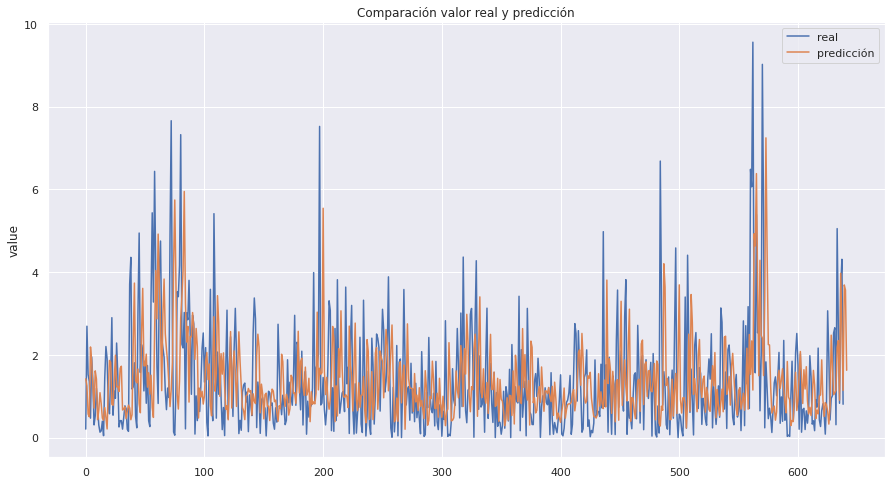

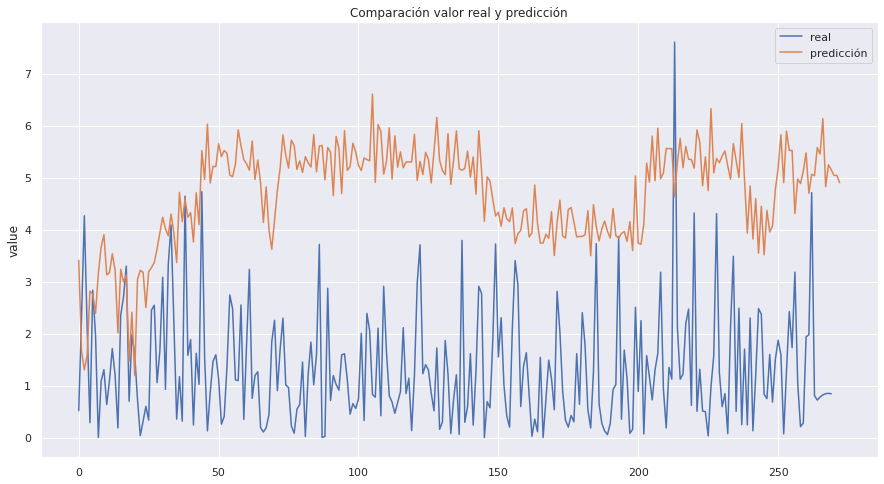

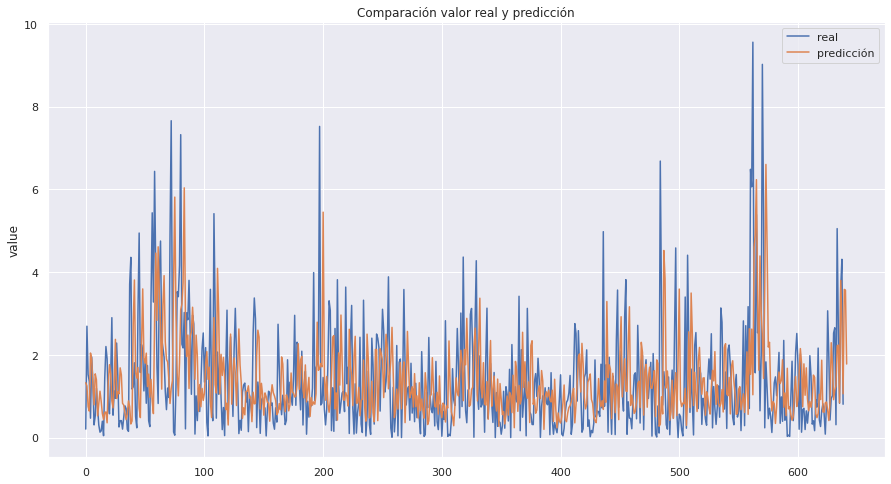

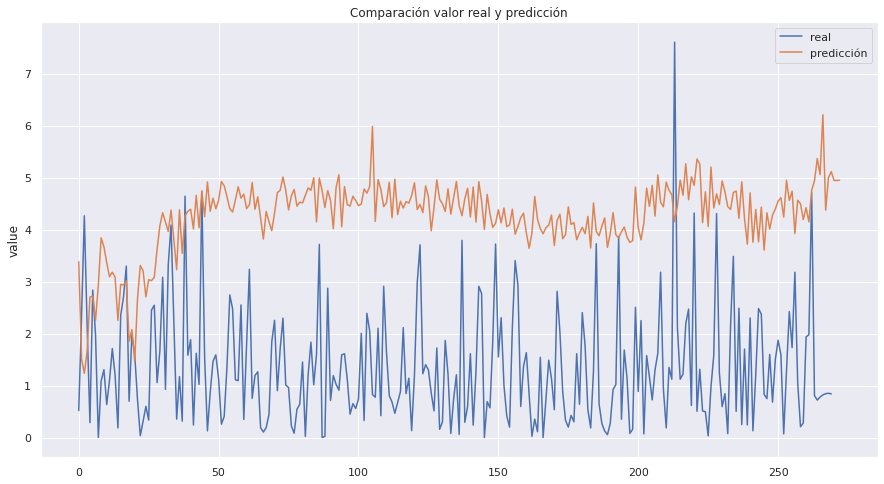

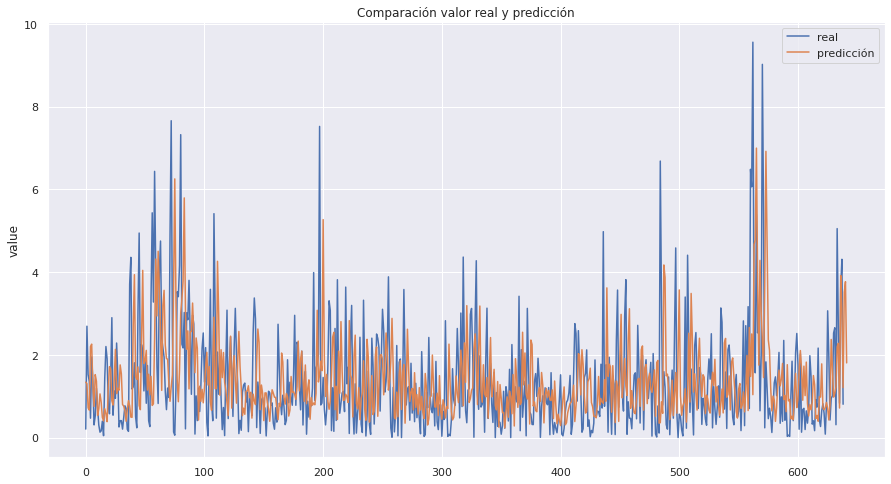

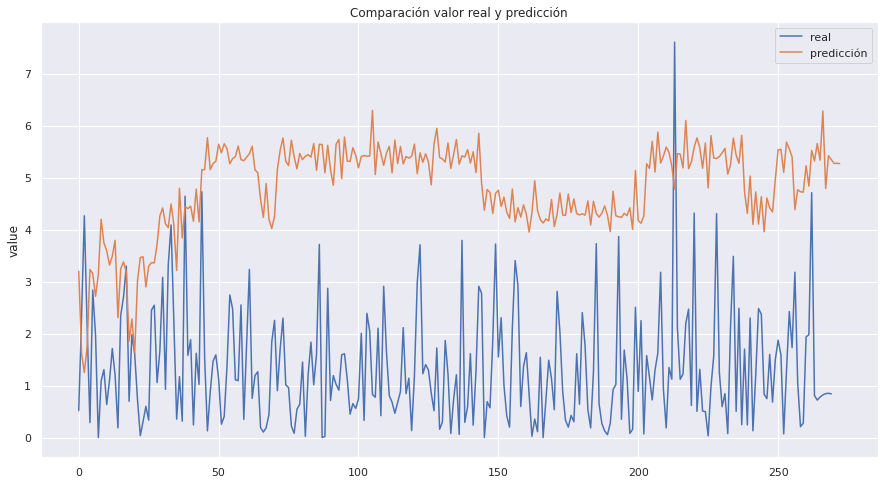

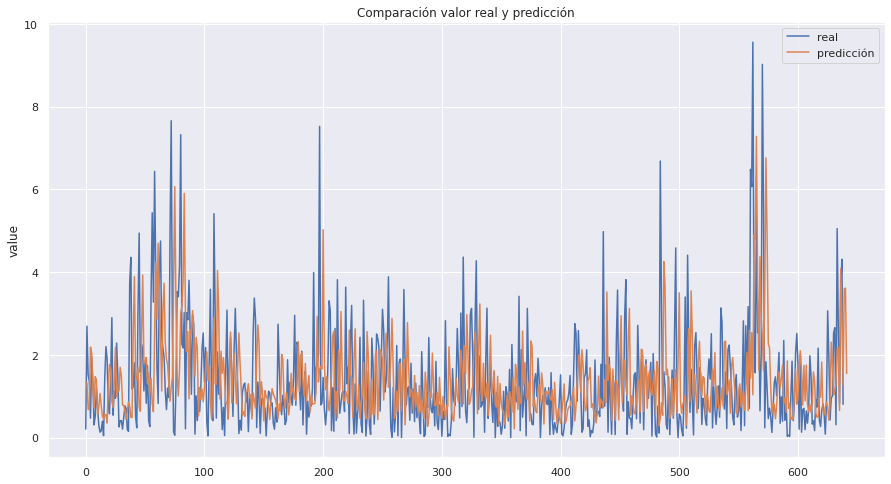

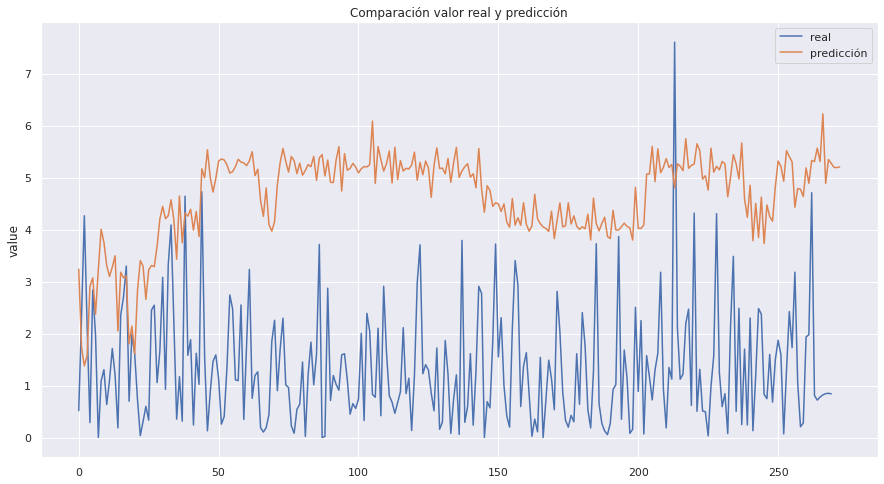

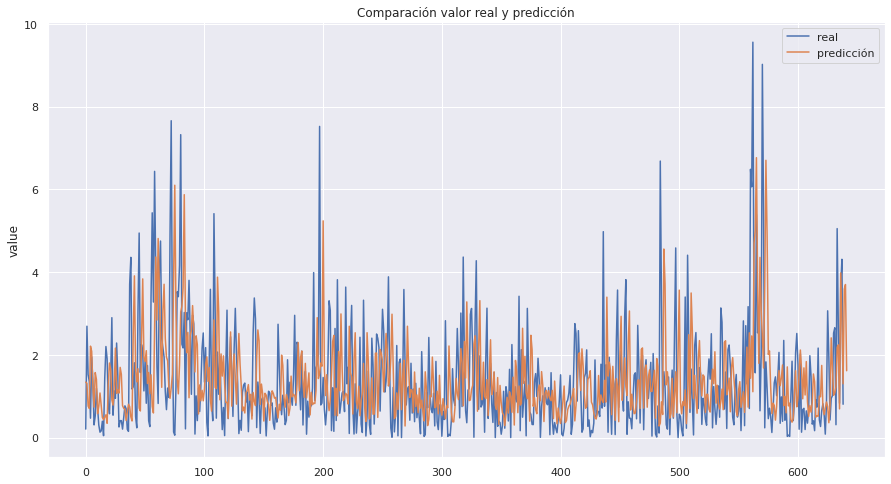

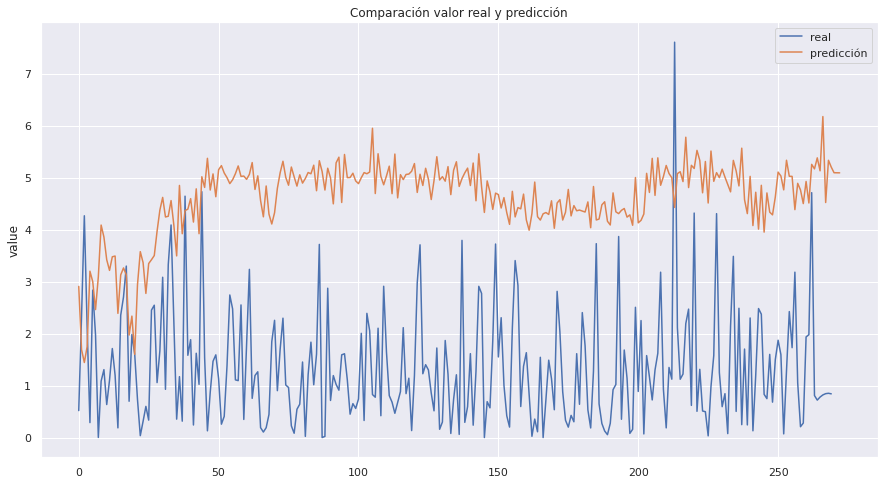

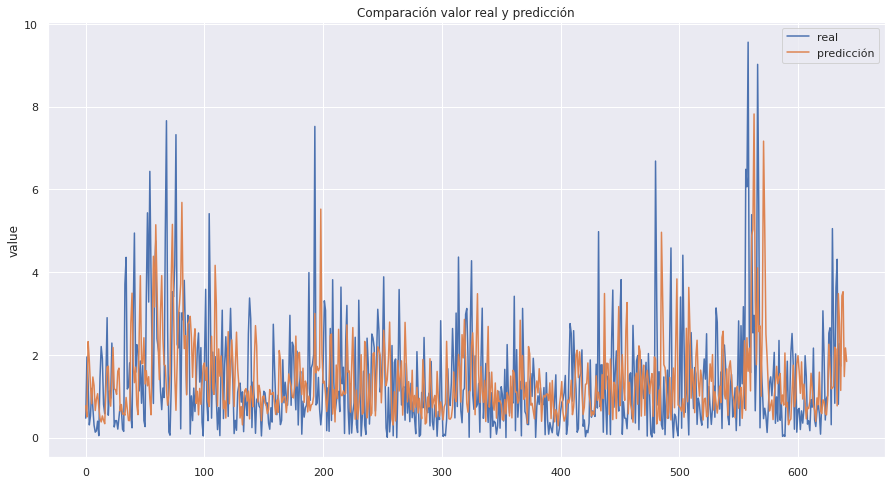

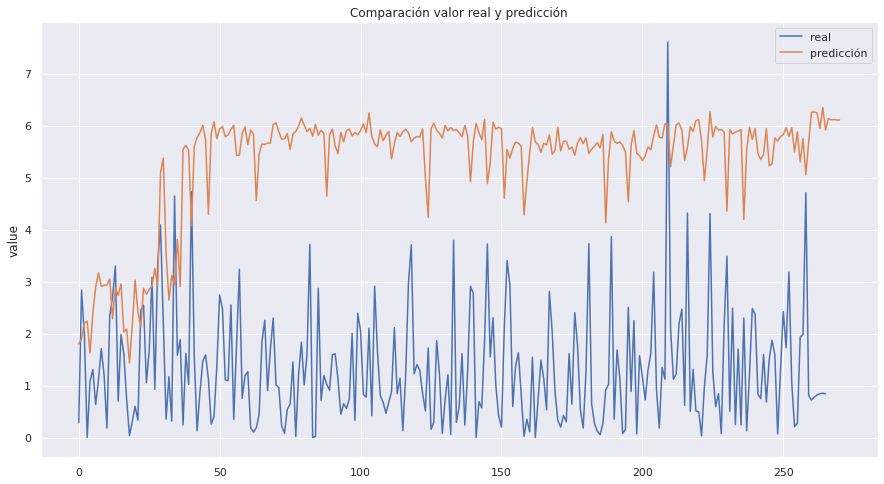

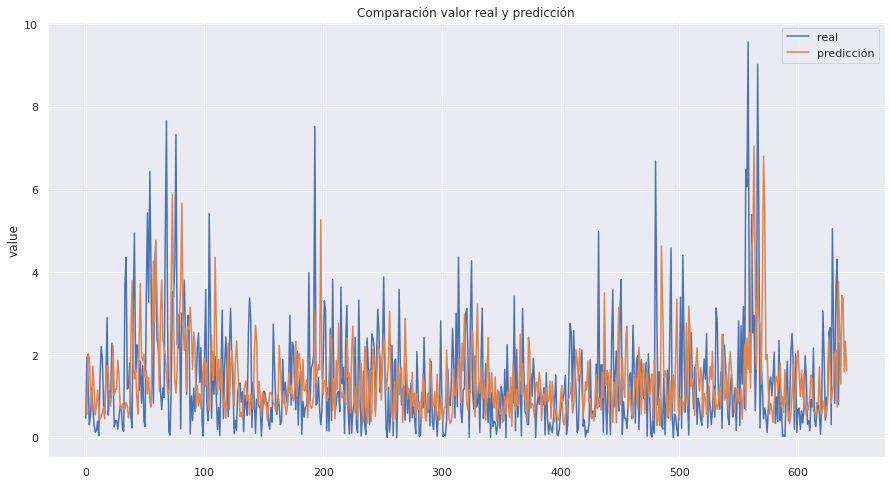

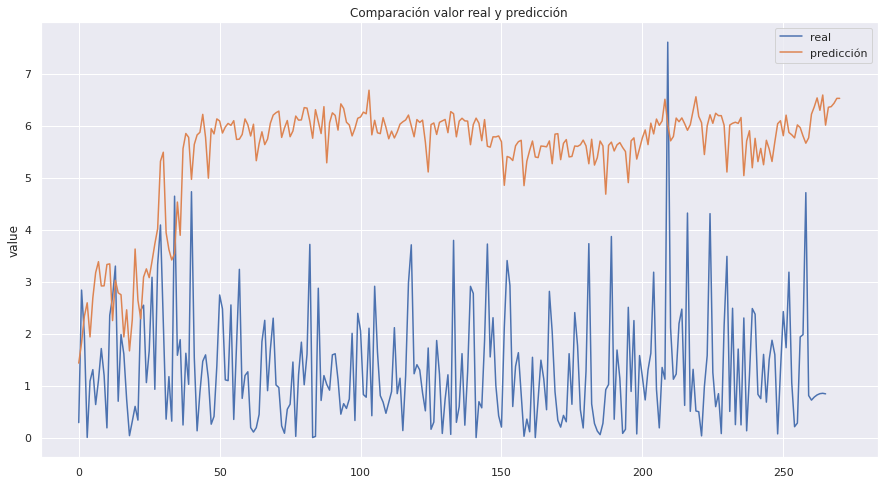

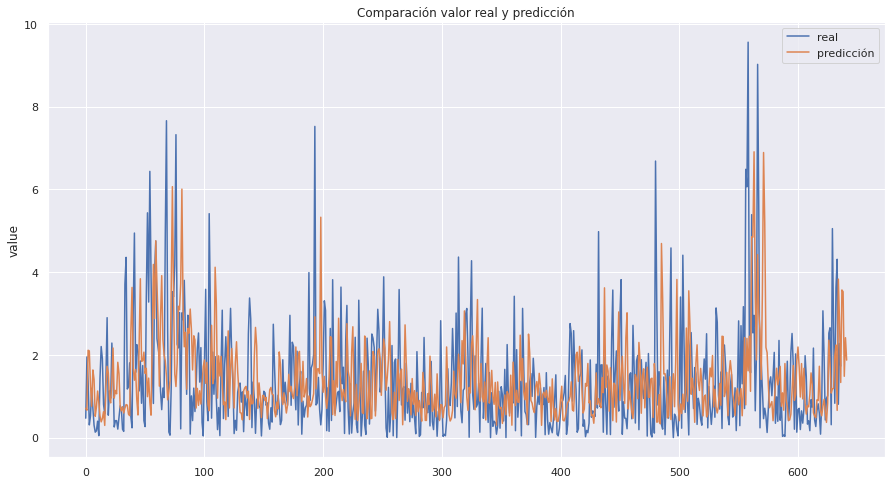

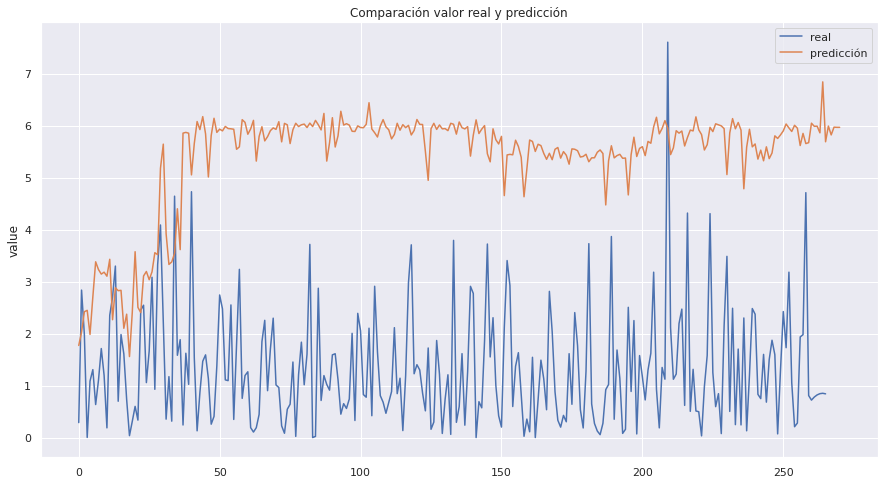

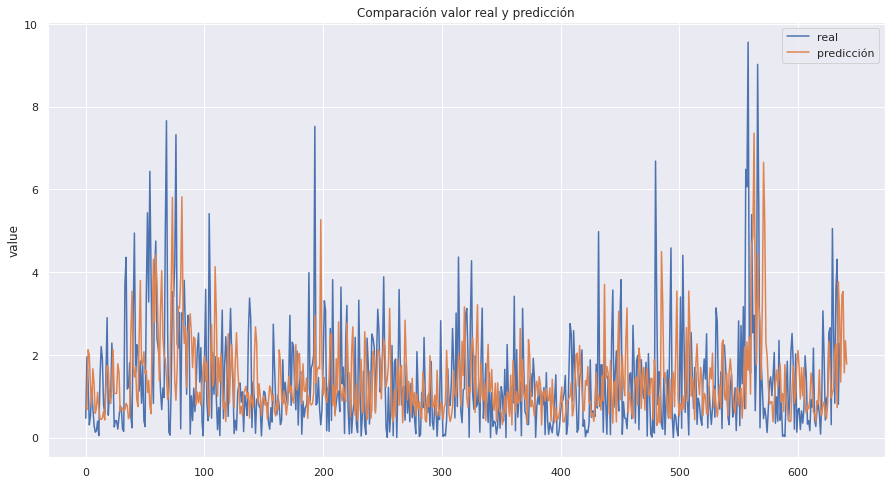

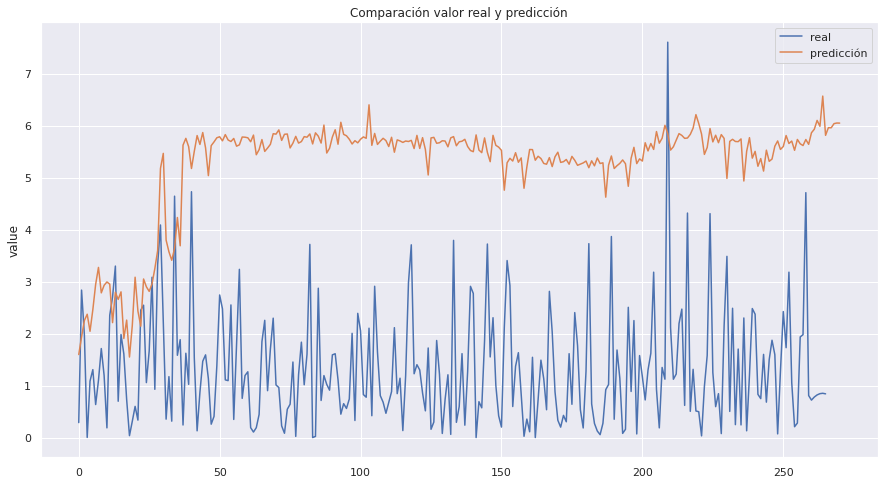

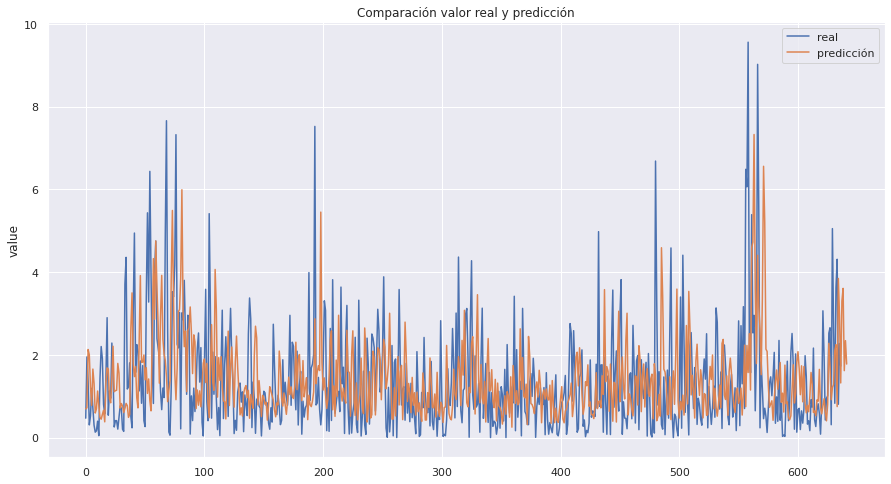

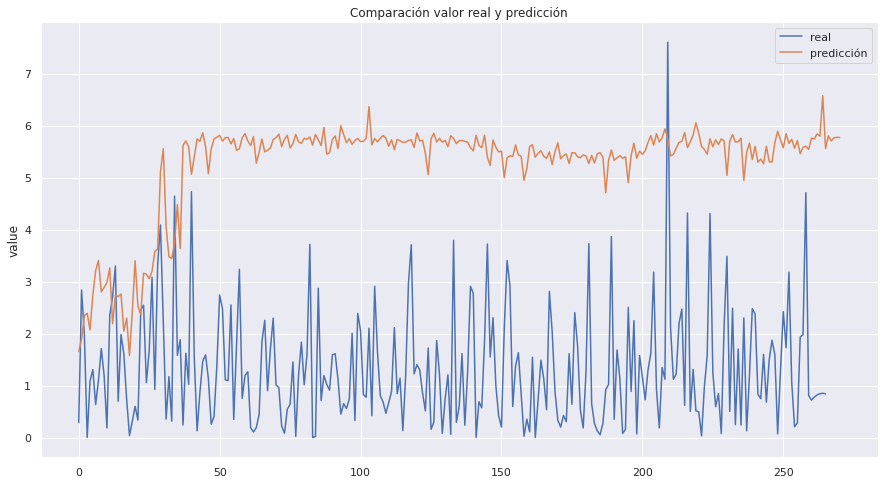

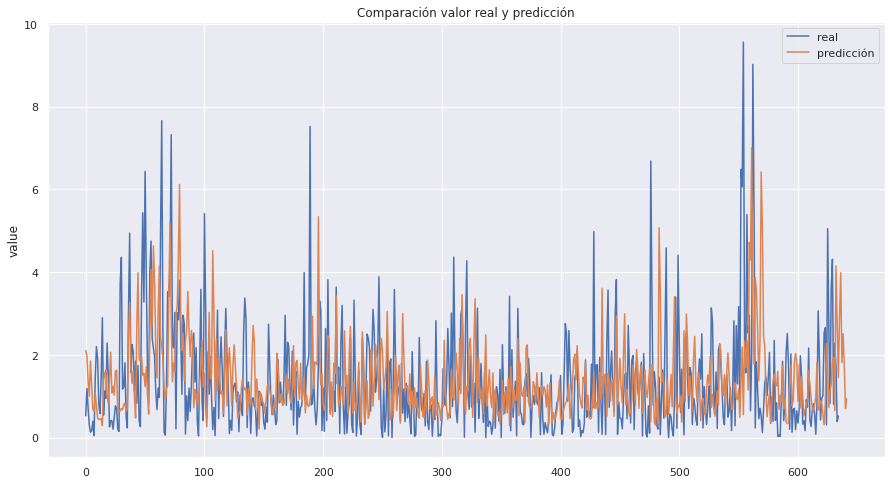

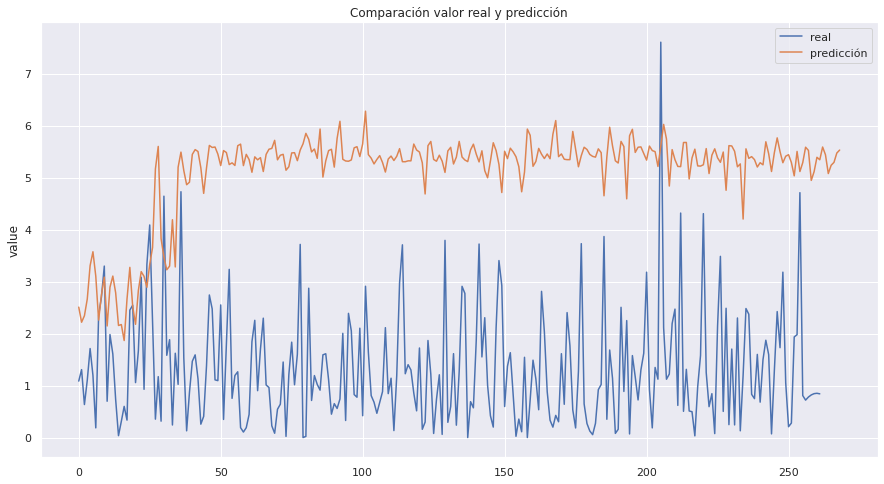

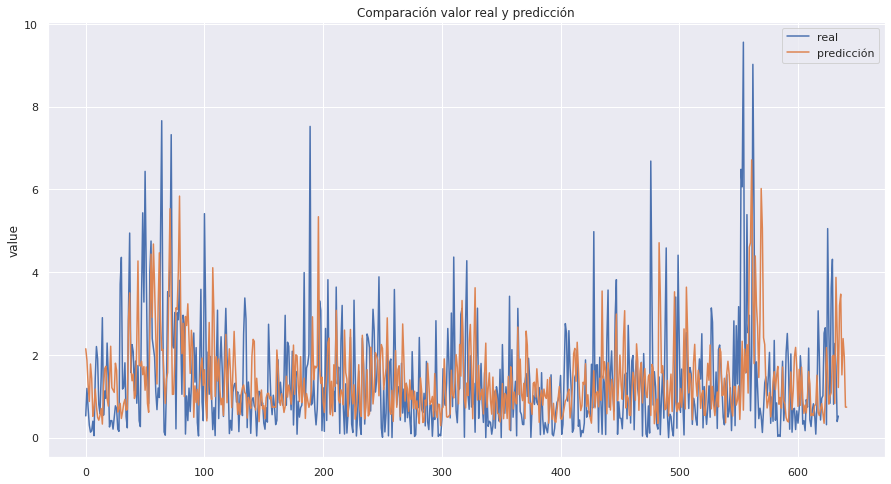

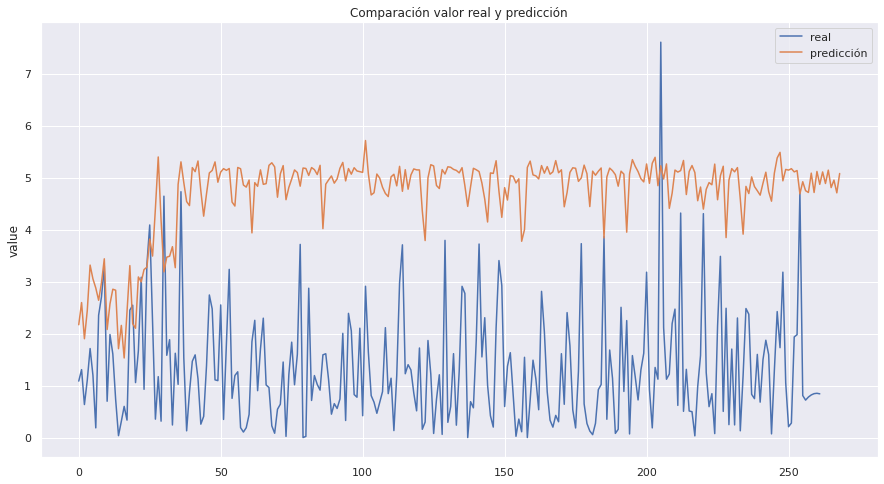

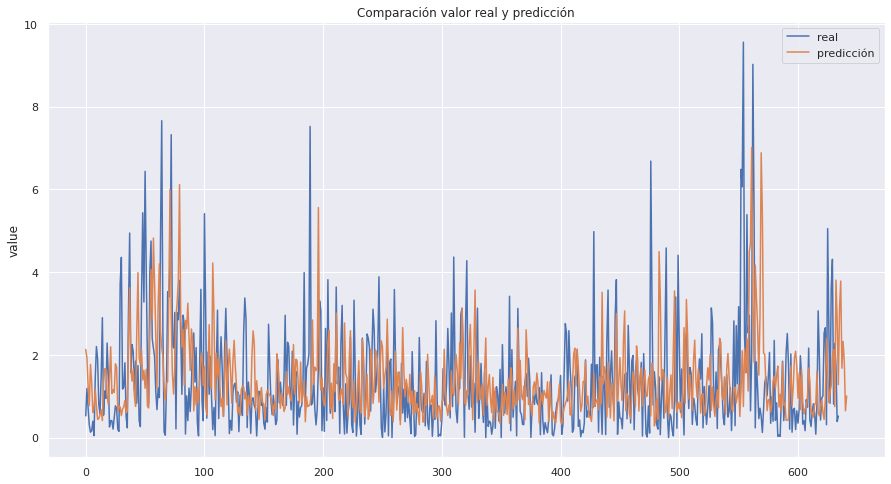

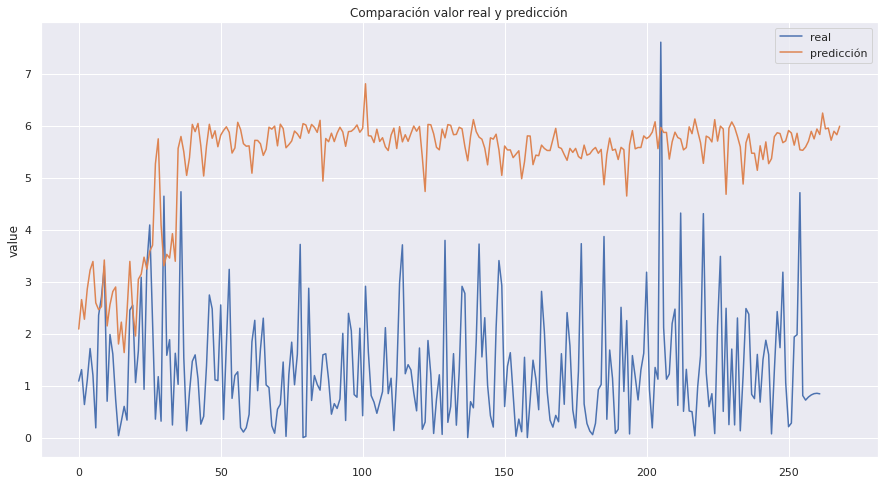

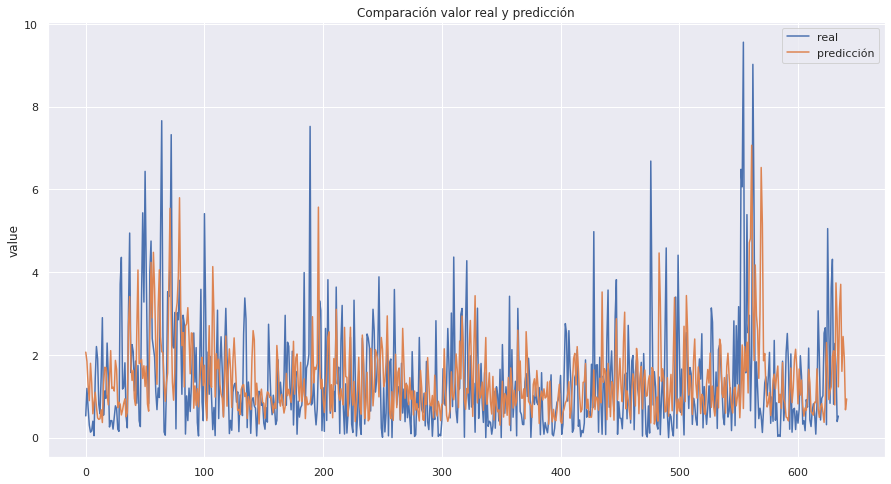

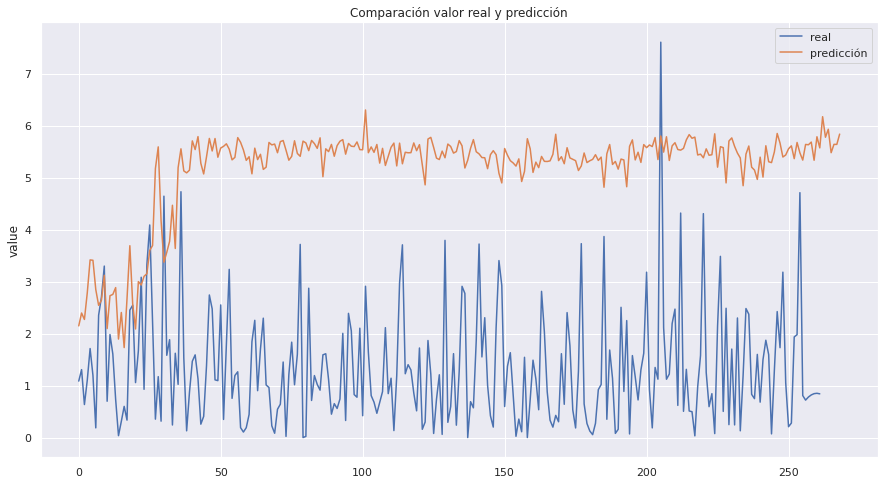

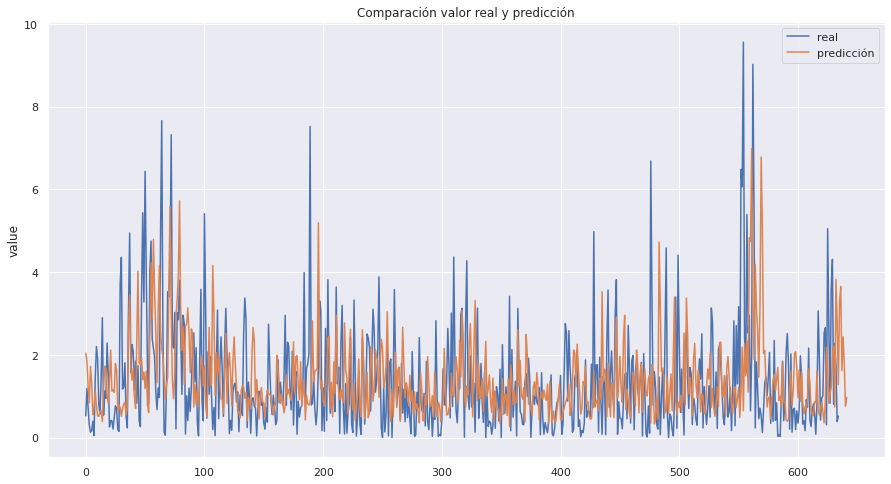

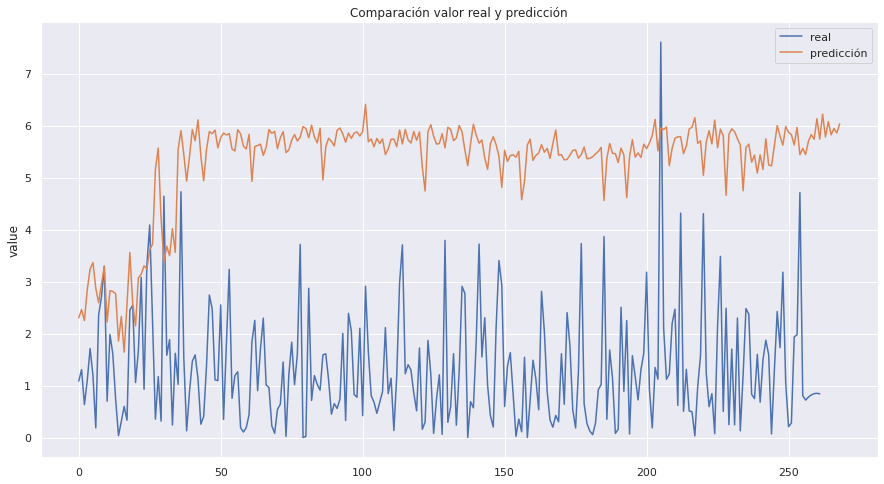

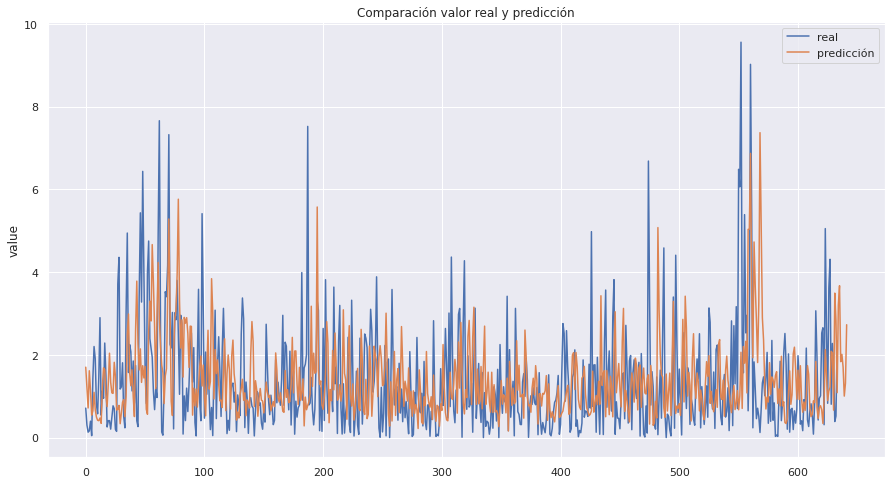

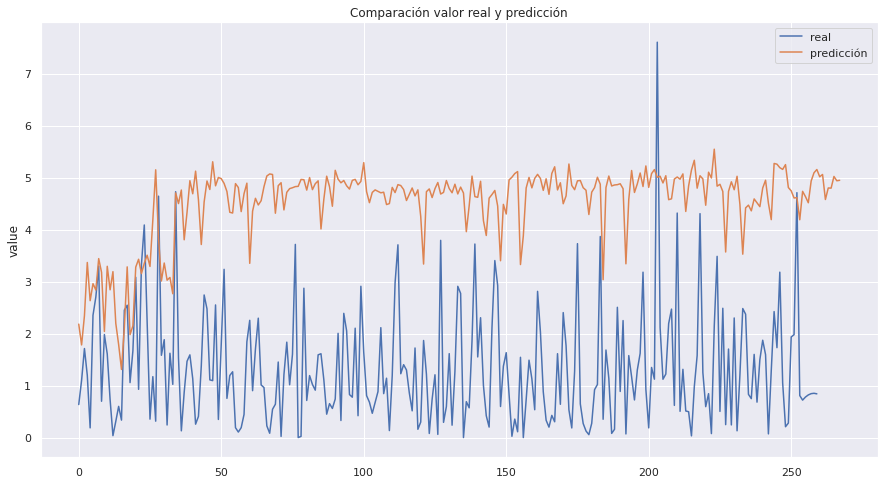

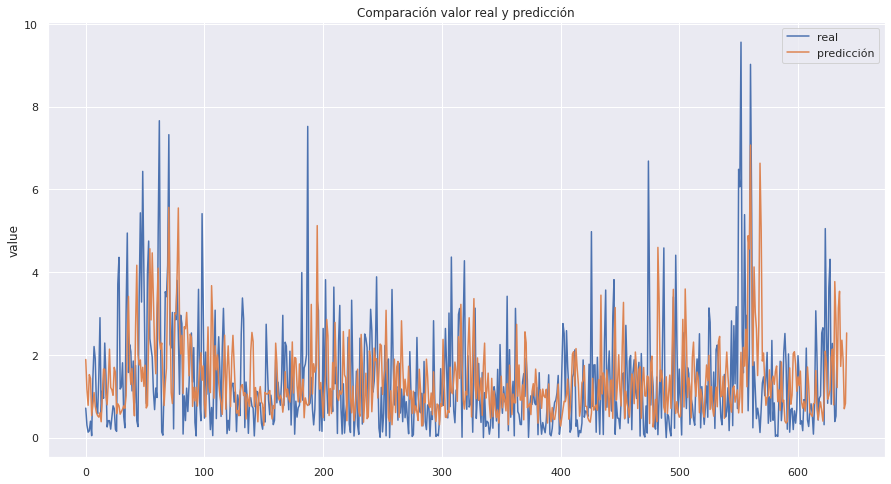

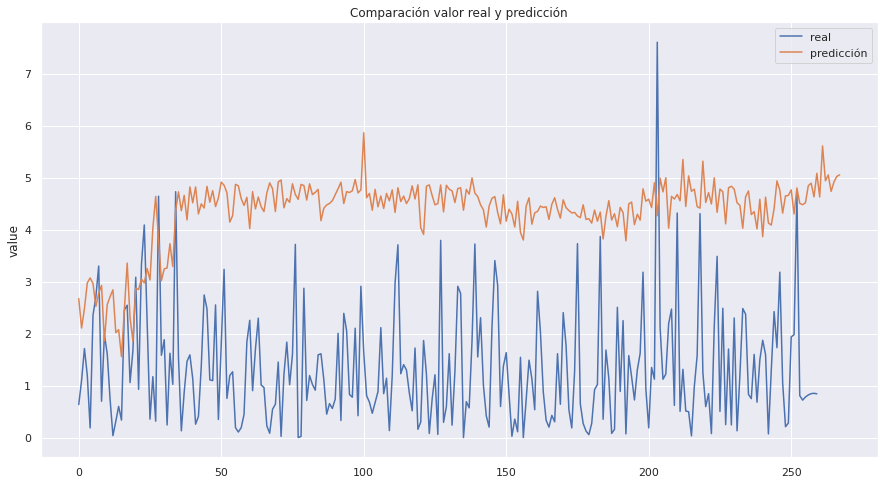

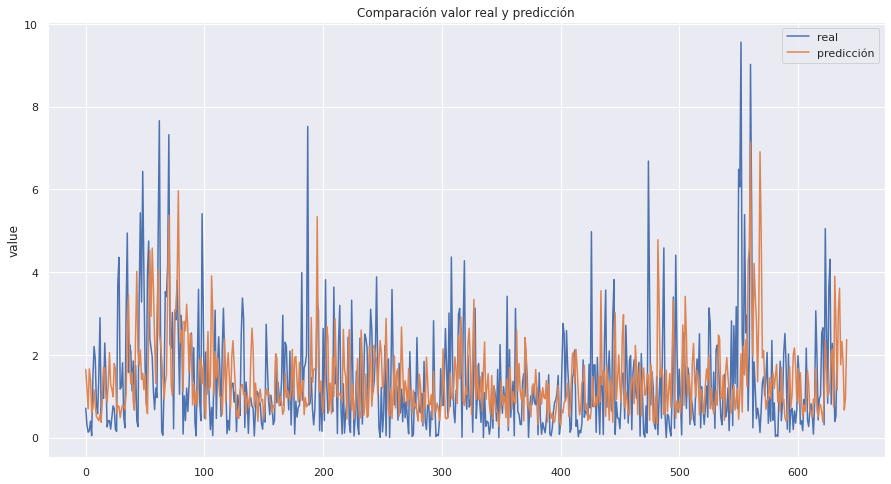

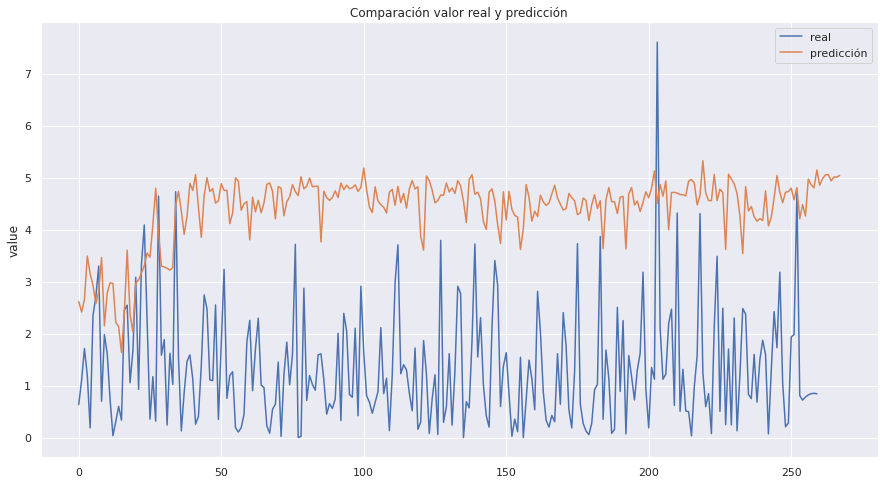

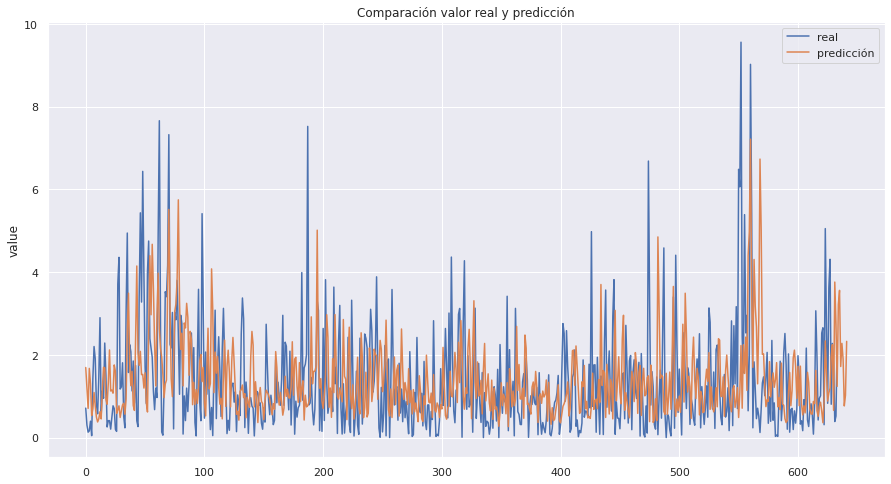

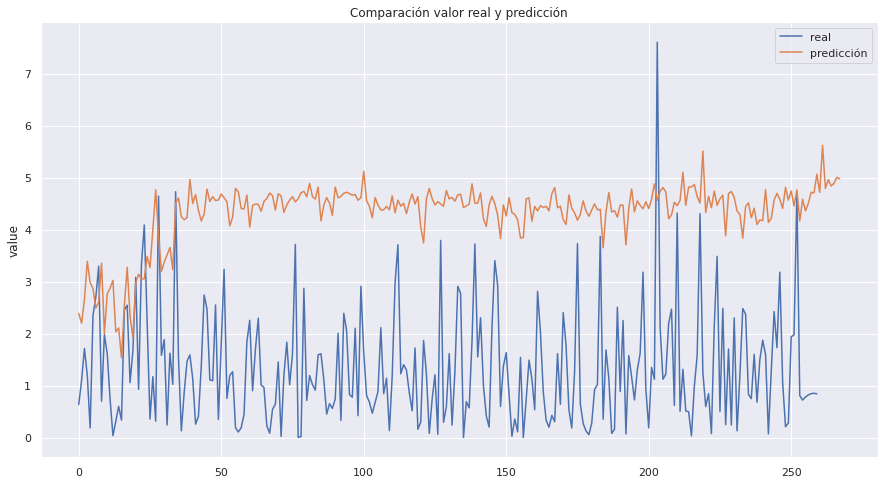

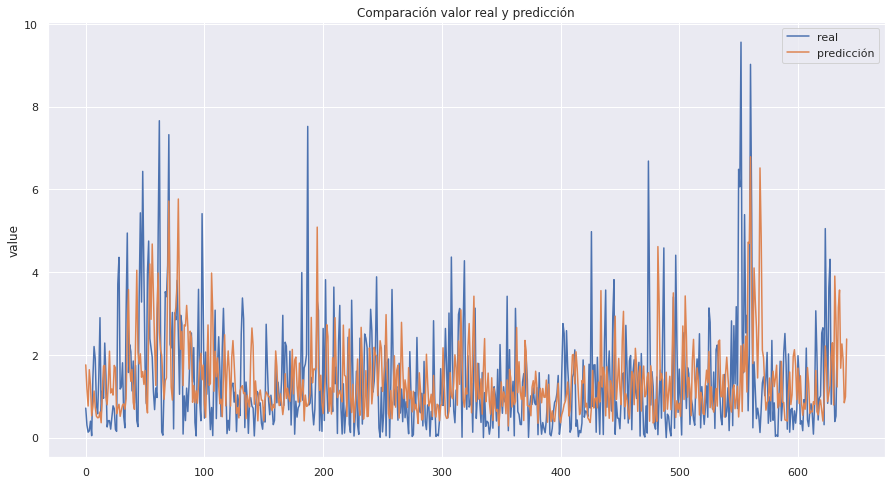

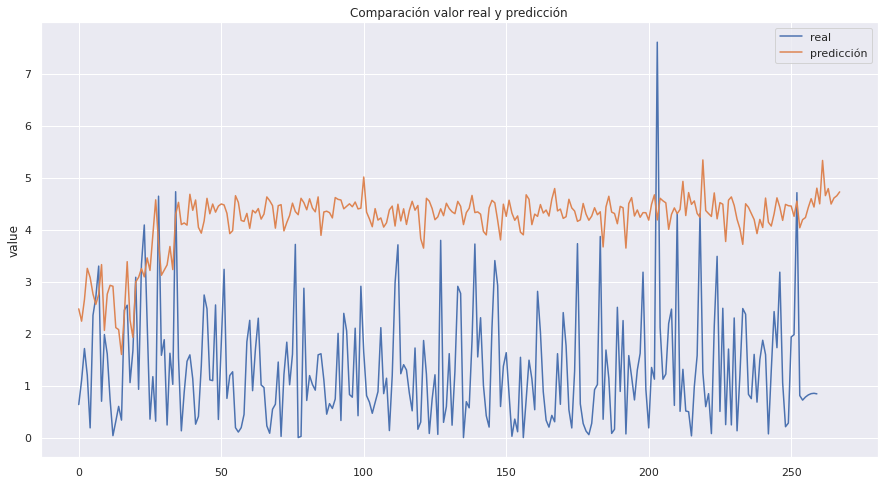

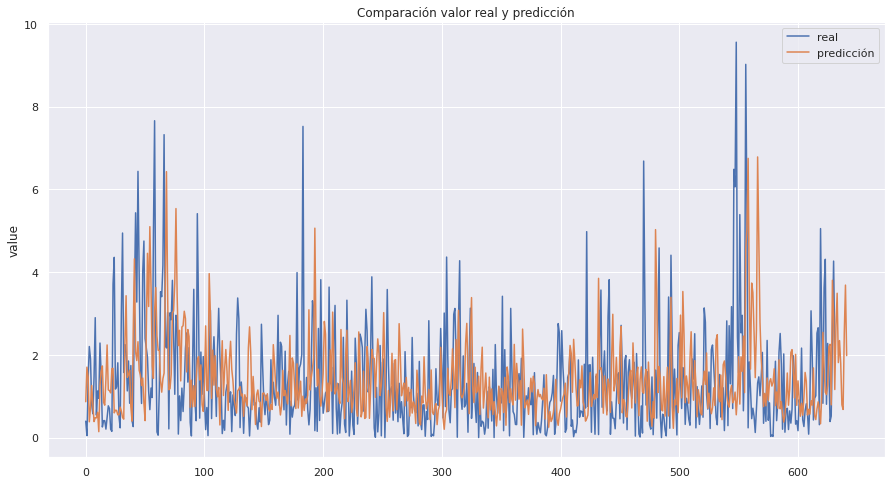

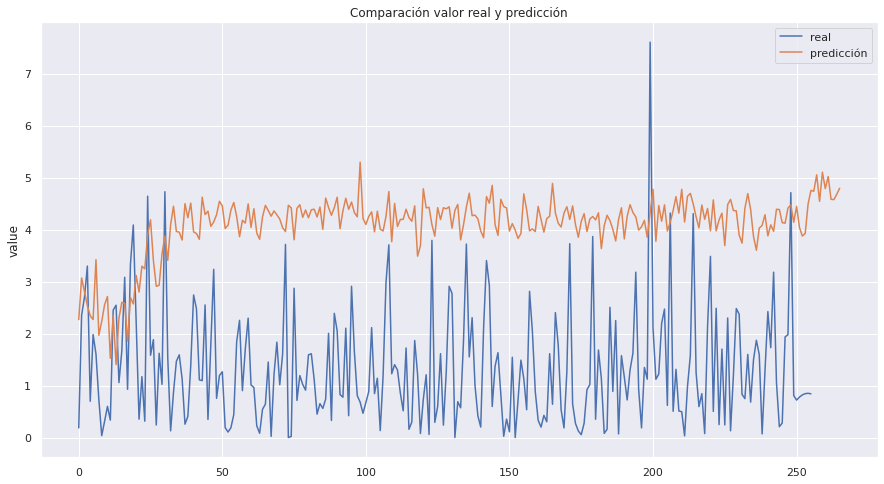

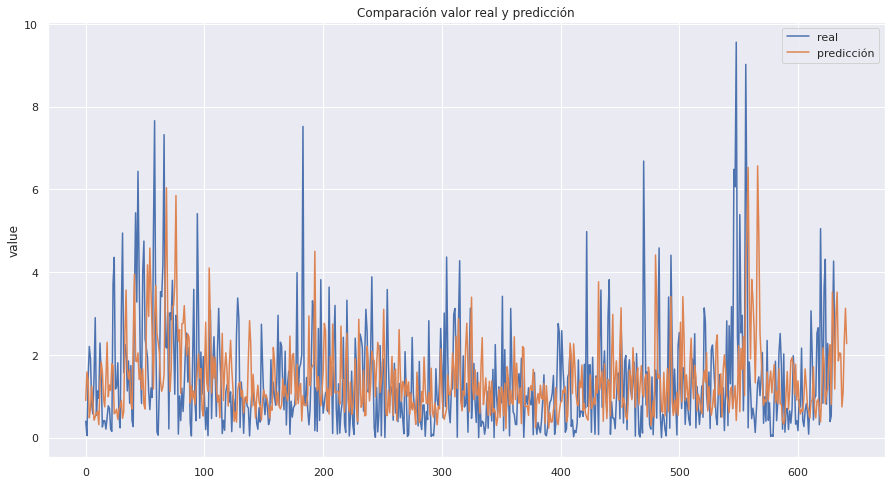

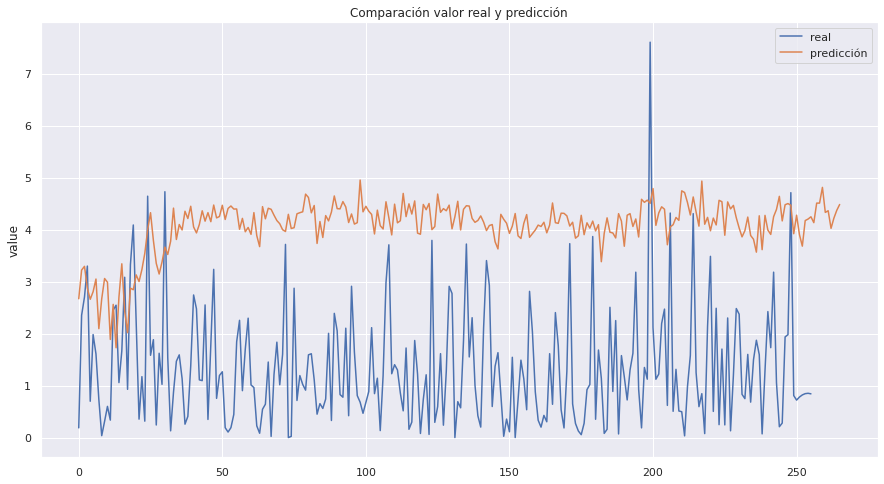

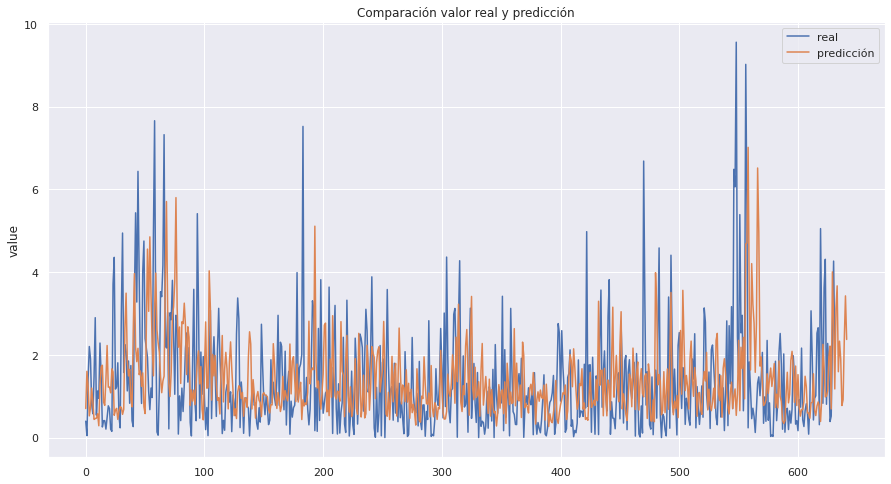

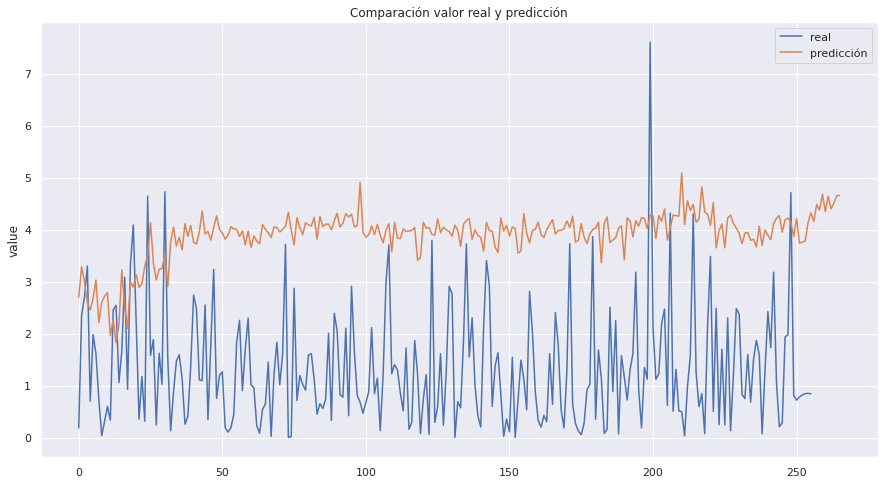

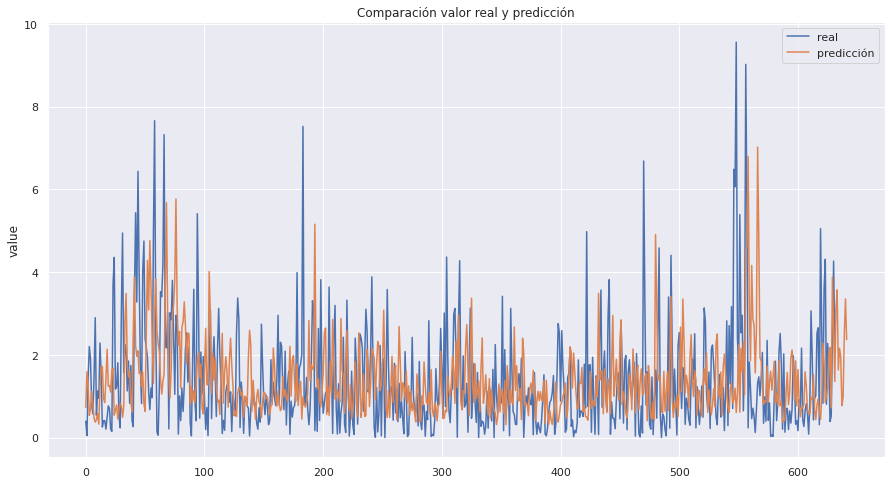

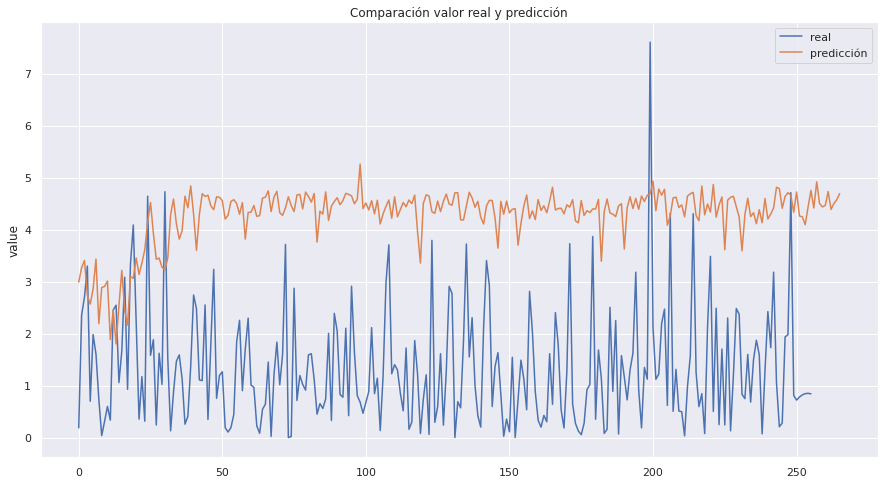

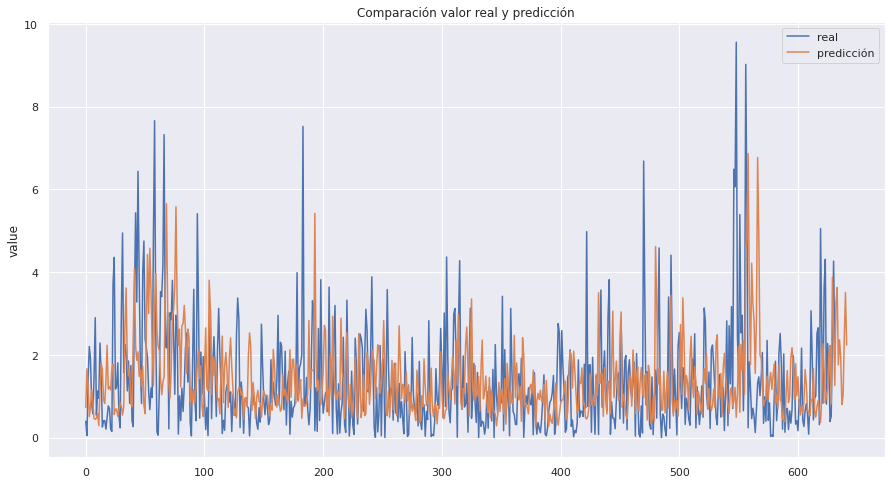

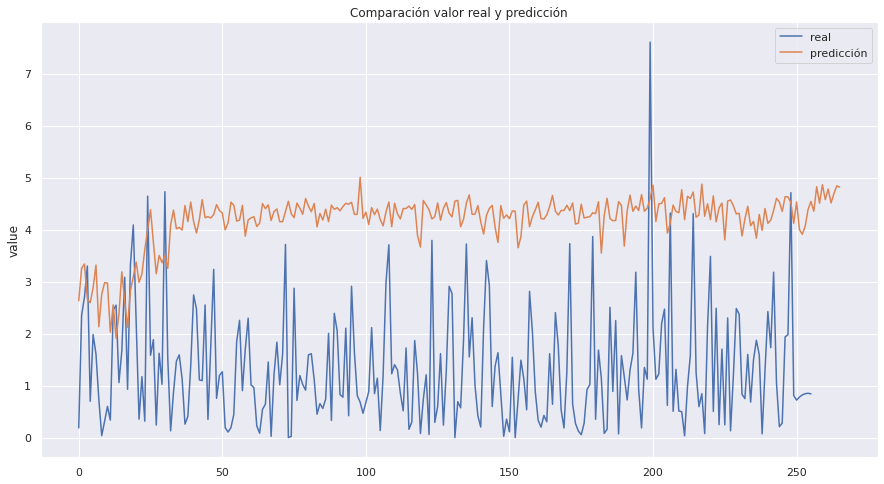

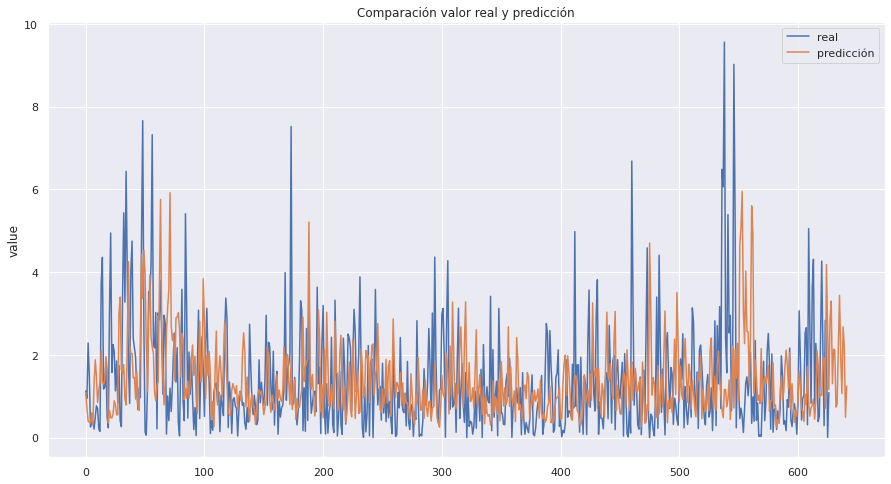

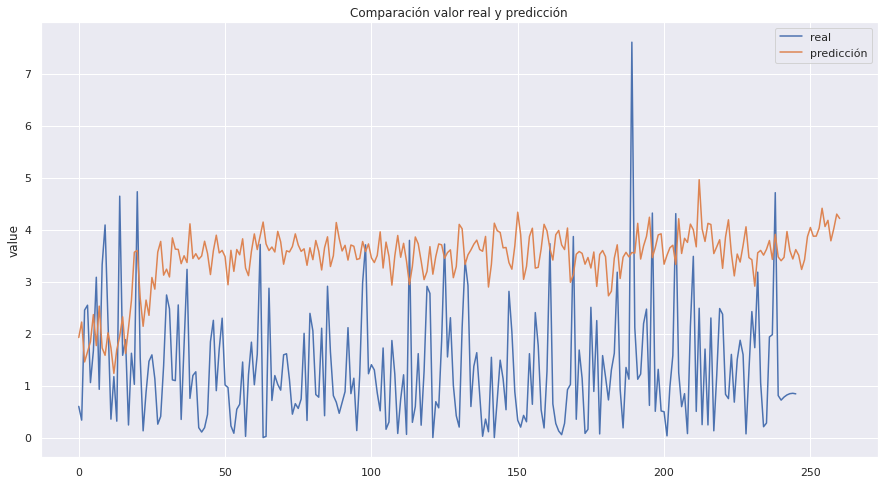

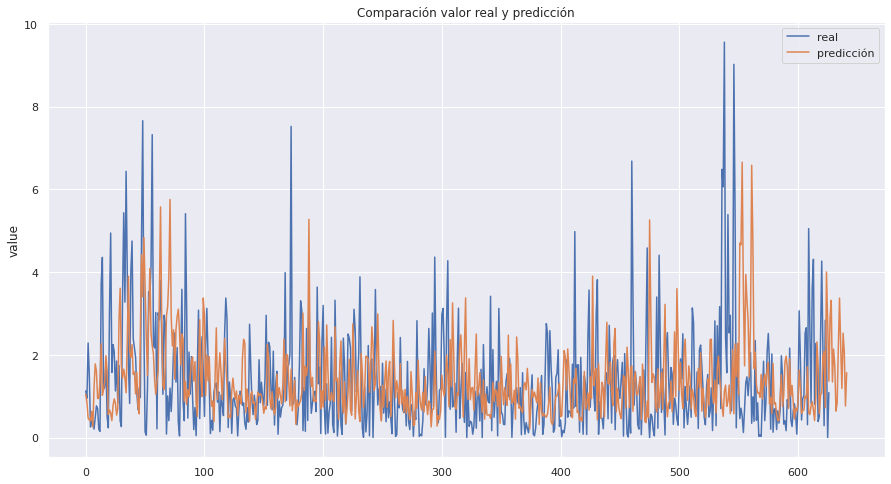

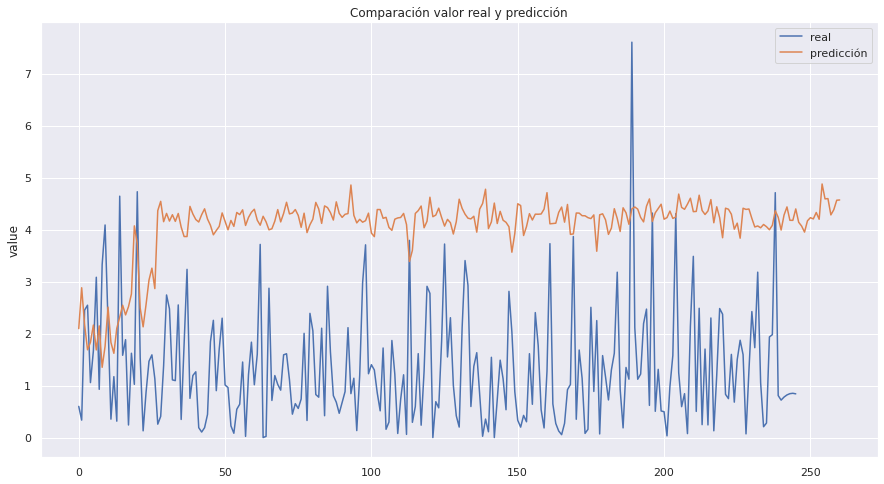

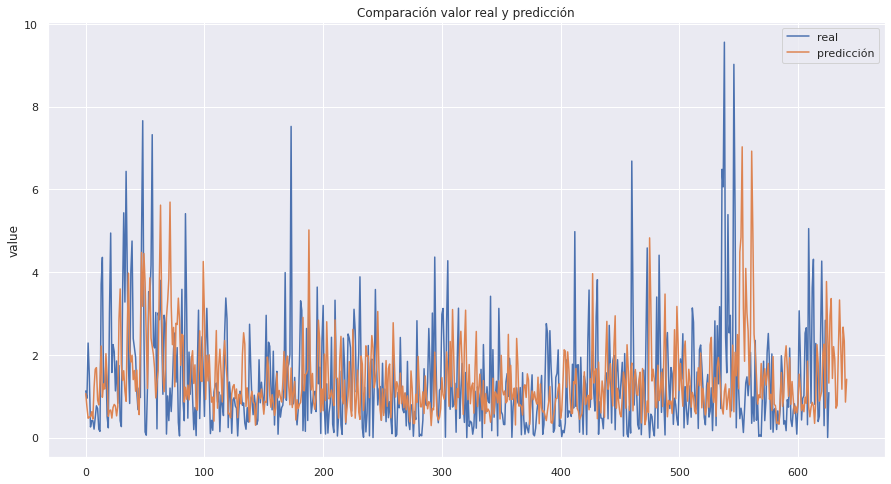

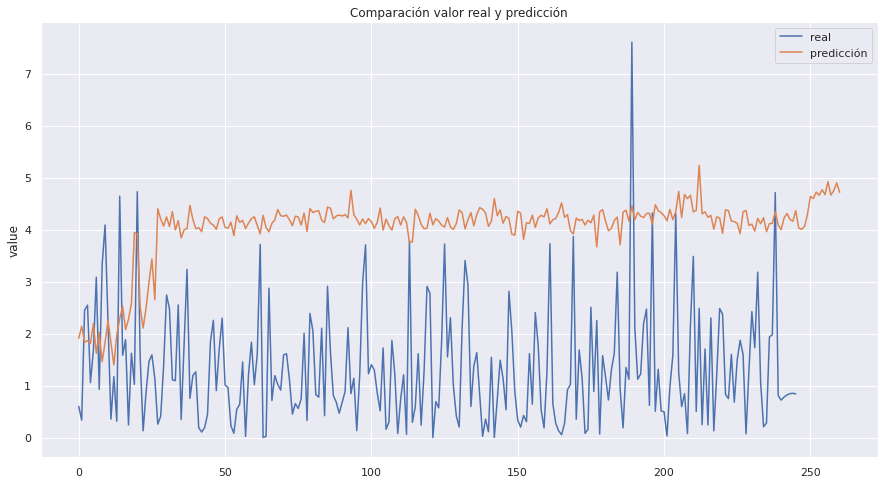

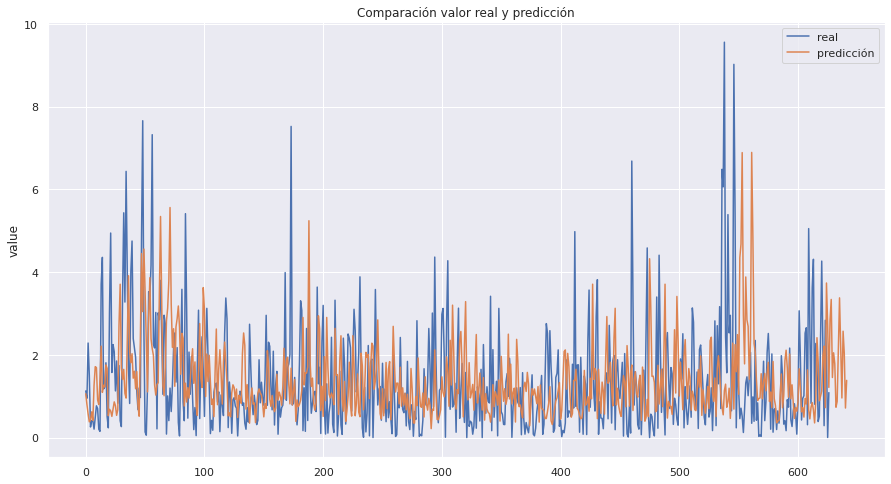

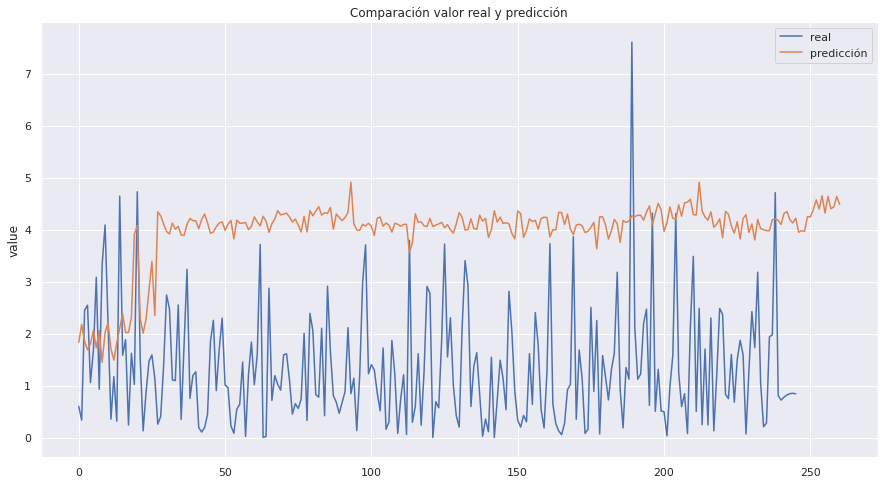

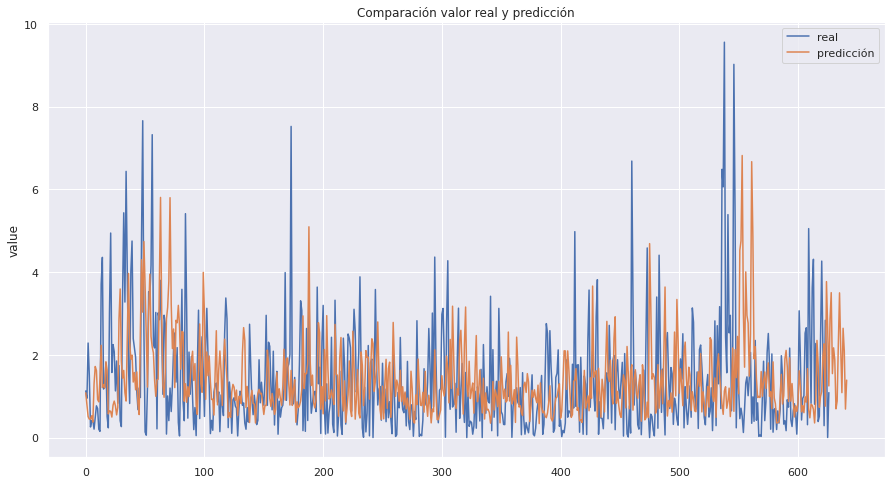

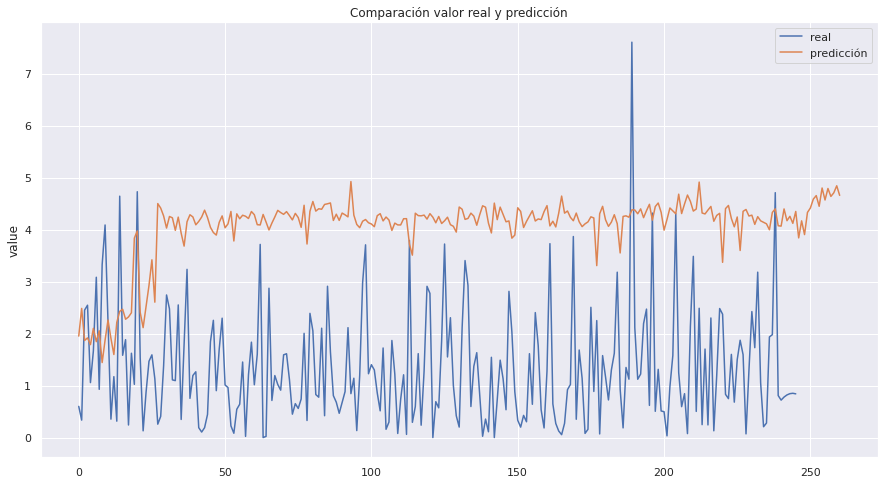

In [11]:
lags=[3,5,7,8,10,15]
n_estimators=[50,100,200,300,500]
results_models={i:{} for i in lags}
for lg in lags:
    for est in n_estimators:
        results_models[lg][est]=Model(df_data.copy(),df_label.copy(),lg,est)